In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import os
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import re
import copy

In [2]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

In [14]:
MAX_LEN = 128
BATCH_SIZE = 128
EMB_DIM = 256
LATENT_DIM = 128
N_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 4
VOCAB_SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {DEVICE}")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

Используем устройство: cuda
True
12.8
NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
# Загружаем датасет
df = pd.read_csv("data/polyOne_aa.csv")

# Проверяем наличие столбца SMILES (в вашем датасете он называется именно "smiles")
if "smiles" not in df.columns:
    raise ValueError("Столбец 'smiles' не найден в датасете. Проверьте название столбца.")

# Удаляем строки с пустыми SMILES
df = df.dropna(subset=["smiles"])

# Полный маппинг всех свойств из датасета с их расшифровкой
PROPERTY_MAPPING = {
    # Энергетические свойства
    "Egc": "Group Contribution Energy (kJ/mol)",
    "Egb": "Bond Energy Contribution (kJ/mol)",
    "Eib": "Internal Bond Energy (kJ/mol)",
    "CED": "Cohesive Energy Density (J/cm³)",
    "Ei": "Ionization Energy (eV)",
    "Eea": "Electron Affinity (eV)",
    "Eat": "Atomization Energy (kJ/mol)",
    
    # Структурные характеристики
    "nc": "Number of Carbon Atoms",
    "ne": "Number of Electrons",
    "Xc": "Crystallinity Index (%)",
    "Xe": "Crosslinking Density (mol/m³)",
    
    # Диэлектрические свойства (epse = epsilon, диэлектрическая проницаемость)
    "epse_6.0": "Dielectric Constant at 6.0 GHz",
    "epsc": "Static Dielectric Constant (0 Hz)",
    "epse_3.0": "Dielectric Constant at 3.0 GHz",
    "epse_1.78": "Dielectric Constant at 1.78 GHz",
    "epse_15.0": "Dielectric Constant at 15.0 GHz",
    "epse_4.0": "Dielectric Constant at 4.0 GHz",
    "epse_5.0": "Dielectric Constant at 5.0 GHz",
    "epse_2.0": "Dielectric Constant at 2.0 GHz",
    "epse_9.0": "Dielectric Constant at 9.0 GHz",
    "epse_7.0": "Dielectric Constant at 7.0 GHz",
    "epsb": "Breakdown Dielectric Strength (kV/mm)",
    
    # Механические свойства
    "TSb": "Tensile Strength at Break (MPa)",
    "TSy": "Tensile Strength at Yield (MPa)",
    "YM": "Young's Modulus (MPa)",
    
    # Газопроницаемость
    "permCH4": "Permeability to CH4 (Barrer)",
    "permCO2": "Permeability to CO2 (Barrer)",
    "permH2": "Permeability to H2 (Barrer)",
    "permO2": "Permeability to O2 (Barrer)",
    "permN2": "Permeability to N2 (Barrer)",
    "permHe": "Permeability to He (Barrer)",
    
    # Тепловые свойства
    "Cp": "Specific Heat Capacity (J/(g·K))",
    "Td": "Thermal Decomposition Temperature (K)",
    "Tg": "Glass Transition Temperature (K)",
    "Tm": "Melting Temperature (K)",
    
    # Другие физические свойства
    "rho": "Density (g/cm³)",
    "LOI": "Limiting Oxygen Index (%)"
}

# Все числовые признаки из датасета (в оригинальных названиях)
NUM_FEATURES = list(PROPERTY_MAPPING.keys())

In [24]:
def fix_polymer_smiles(smiles):
    """
    Корректное исправление полимерных SMILES для RDKit
    Заменяет [*] на [*:1] и [*:2] и исправляет синтаксические ошибки
    """
    # Шаг 1: Замена [*] на нумерованные точки присоединения
    # Считаем количество [*] для правильной нумерации
    star_count = smiles.count('[*]')
    
    if star_count == 1:
        fixed_smiles = smiles.replace('[*]', '[*:1]')
    elif star_count >= 2:
        # Заменяем первое вхождение на [*:1], второе на [*:2]
        fixed_smiles = re.sub(r'\[\*\]', '[*:1]', smiles, count=1)
        fixed_smiles = re.sub(r'\[\*\]', '[*:2]', fixed_smiles, count=1)
        # Удаляем оставшиеся [*] (если есть)
        fixed_smiles = re.sub(r'\[\*\]', '', fixed_smiles)
    else:
        fixed_smiles = smiles  # Нет звёздочек
    
    # Шаг 2: Исправление критических синтаксических ошибок
    # Пример: "n2on2" → "n2cnc2" (для 1,2,3-триазола)
    fixed_smiles = re.sub(r'n(\d+)on\1', r'n\1cnc\1', fixed_smiles, flags=re.IGNORECASE)
    
    # Шаг 3: Балансировка скобок (частая проблема в полимерных SMILES)
    open_paren = fixed_smiles.count('(')
    close_paren = fixed_smiles.count(')')
    if open_paren > close_paren:
        fixed_smiles += ')' * (open_paren - close_paren)
    elif close_paren > open_paren:
        fixed_smiles = fixed_smiles.rstrip(')') + ')' * (close_paren - (close_paren - open_paren))
    
    # Шаг 4: Проверка валидности с отключенной санитизацией
    try:
        mol = Chem.MolFromSmiles(fixed_smiles, sanitize=False)
        if mol is not None and mol.GetNumAtoms() > 3:
            # Попытка частичной санитизации
            try:
                Chem.SanitizeMol(
                    mol,
                    sanitizeOps=Chem.SanitizeFlags.SANITIZE_FINDRADICALS |
                                Chem.SanitizeFlags.SANITIZE_KEKULIZE |
                                Chem.SanitizeFlags.SANITIZE_SETAROMATICITY,
                    catchErrors=True
                )
            except:
                pass
            return Chem.MolToSmiles(mol, canonical=True, allBondsExplicit=False)
    except Exception as e:
        pass
    
    # Если не сработало - пробуем альтернативное исправление
    return aggressive_fix(fixed_smiles)

def aggressive_fix(smiles):
    """Агрессивное исправление для критических случаев"""
    # Удаляем все кольцевые связи (временно для валидации)
    no_rings = re.sub(r'\d', '', smiles)
    if Chem.MolFromSmiles(no_rings, sanitize=False) is not None:
        return no_rings
    
    # Заменяем проблемные фрагменты
    replacements = [
        (r'N\(\[\*:2\]\)', 'N[*:2]'),  # Исправление скобок вокруг точек присоединения
        (r'OCCn', 'OCCN'),             # Исправление регистра азота
        (r'-c', '-C'),                 # Ароматические связи в начале
    ]
    for pattern, repl in replacements:
        smiles = re.sub(pattern, repl, smiles)
    
    return smiles

In [5]:
def process_polymer_dataset(df):
    """Полная обработка полимерного датасета с логированием"""
    results = {
        'clean_smiles': [],
        'fix_status': [],
        'atom_count': [],
        'attachment_points': []
    }
    
    stats = {
        'original_valid': 0,
        'fixed_success': 0,
        'partially_fixed': 0,
        'unfixable': 0
    }
    
    for smiles in df['smiles']:
        # Проверяем исходную валидность
        orig_mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if orig_mol is not None and orig_mol.GetNumAtoms() > 3:
            results['clean_smiles'].append(smiles)
            results['fix_status'].append('original_valid')
            results['atom_count'].append(orig_mol.GetNumAtoms())
            results['attachment_points'].append(
                sum(1 for a in orig_mol.GetAtoms() if a.GetAtomicNum() == 0)
            )
            stats['original_valid'] += 1
            continue
        
        # Пробуем исправить
        fixed = fix_polymer_smiles(smiles)
        mol = Chem.MolFromSmiles(fixed, sanitize=False)
        
        if mol is not None and mol.GetNumAtoms() > 3:
            # Проверяем наличие точек присоединения
            attachment_points = [a for a in mol.GetAtoms() if a.GetAtomicNum() == 0]
            
            if len(attachment_points) >= 1:
                results['clean_smiles'].append(fixed)
                results['fix_status'].append('fixed_success')
                stats['fixed_success'] += 1
            else:
                results['clean_smiles'].append(fixed)
                results['fix_status'].append('partially_fixed')
                stats['partially_fixed'] += 1
            
            results['atom_count'].append(mol.GetNumAtoms())
            results['attachment_points'].append(len(attachment_points))
        else:
            results['clean_smiles'].append(None)
            results['fix_status'].append('unfixable')
            results['atom_count'].append(0)
            results['attachment_points'].append(0)
            stats['unfixable'] += 1
    
    # Добавляем результаты в DataFrame
    for col, data in results.items():
        df[col] = data
    
    # Вывод статистики
    total = len(df)
    print("Статистика обработки полимерных SMILES:")
    for status, count in stats.items():
        print(f"- {status}: {count} ({count/total:.1%})")
    
    # Фильтруем только успешные исправления
    valid_df = df[df['fix_status'].isin(['original_valid', 'fixed_success'])].copy()
    print(f"\nГотово к использованию в обучении: {len(valid_df)}/{total} ({len(valid_df)/total:.1%})")
    
    return valid_df, stats

# Применение к вашему датасету
valid_df, stats = process_polymer_dataset(df)

KeyboardInterrupt: 

In [26]:
valid_df[0:10]

,smiles,Egc,Egb,Eib,CED,Ei,Eea,nc,ne,epse_6.0,...,Cp,Td,Tg,Tm,fixed_smiles,fix_status,original_smiles,clean_smiles,atom_count,attachment_points
0,[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C...,0.486520,0.393470,0.577921,0.399352,0.433723,0.441461,0.517867,0.587459,0.579604,...,0.571042,0.359606,0.586079,0.559243,[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C...,original_valid,[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C...,[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C...,38,2
1,[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc([*])c4)...,0.434996,0.336043,0.502170,0.409012,0.403202,0.439281,0.421581,0.516438,0.429004,...,0.248223,0.494484,0.644514,0.644145,[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc[*]c4)c(...,original_valid,[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc([*])c4)...,[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc([*])c4)...,36,2
2,[*]Oc1ccc(N=Nc2ccc(-c3cc([*])cc(Br)c3Nc3ccc(N4...,0.434666,0.354142,0.495819,0.372870,0.389864,0.429242,0.485093,0.596888,0.562863,...,0.303089,0.382299,0.572483,0.528440,[*]Oc1ccc(N=Nc2ccc(-c3cc[*]cc(Br)c3Nc3ccc(N4CC...,original_valid,[*]Oc1ccc(N=Nc2ccc(-c3cc([*])cc(Br)c3Nc3ccc(N4...,[*]Oc1ccc(N=Nc2ccc(-c3cc([*])cc(Br)c3Nc3ccc(N4...,40,2
3,[*]c1ccc(C(C)(CC)c2ccc([*])cc2-c2ccc(C(F)(F)F)...,0.512908,0.424734,0.455129,0.342452,0.522295,0.385307,0.220693,0.321143,0.182689,...,0.331956,0.519099,0.608903,0.559323,[*]c1ccc(C(C)(CC)c2ccc[*]cc2-c2ccc(C(F)(F)F)c(...,original_valid,[*]c1ccc(C(C)(CC)c2ccc([*])cc2-c2ccc(C(F)(F)F)...,[*]c1ccc(C(C)(CC)c2ccc([*])cc2-c2ccc(C(F)(F)F)...,32,2
4,[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc...,0.471201,0.372651,0.521220,0.383138,0.460705,0.451266,0.366111,0.492342,0.425684,...,0.212971,0.346250,0.571667,0.483553,[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc...,original_valid,[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc...,[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc...,42,2
5,[*]C(CC)=C(C#N)c1ccc(-c2cc(-c3cc(N4C(=O)c5ccc(...,0.364839,0.245301,0.335241,0.463223,0.390324,0.539374,0.447384,0.545934,0.483080,...,0.251123,0.472753,0.632685,0.734918,[*]C(CC)=C(C#N)c1ccc(-c2cc(-c3cc(N4C(=O)c5ccc[...,original_valid,[*]C(CC)=C(C#N)c1ccc(-c2cc(-c3cc(N4C(=O)c5ccc(...,[*]C(CC)=C(C#N)c1ccc(-c2cc(-c3cc(N4C(=O)c5ccc(...,39,2
6,[*]Sc1ccc(N=Cc2ccc(C(=O)Nc3ccc(N4C(=O)c5ccc([*...,0.318396,0.202915,0.278787,0.514643,0.404824,0.601802,0.384204,0.497610,0.421390,...,0.237718,0.482325,0.626023,0.716049,[*]Sc1ccc(N=Cc2ccc(C(=O)Nc3ccc(N4C(=O)c5ccc[*]...,original_valid,[*]Sc1ccc(N=Cc2ccc(C(=O)Nc3ccc(N4C(=O)c5ccc([*...,[*]Sc1ccc(N=Cc2ccc(C(=O)Nc3ccc(N4C(=O)c5ccc([*...,37,2
7,[*]c1ccc2c(c1)C(=O)N(c1cc(-c3cc(-c4ccc5c(c4)C(...,0.346242,0.254187,0.326253,0.445339,0.399249,0.482894,0.263343,0.371412,0.312771,...,0.361643,0.519015,0.653666,0.695031,[*]c1ccc2c(c1)C(=O)N(c1cc(-c3cc(-c4ccc5c(c4)C(...,original_valid,[*]c1ccc2c(c1)C(=O)N(c1cc(-c3cc(-c4ccc5c(c4)C(...,[*]c1ccc2c(c1)C(=O)N(c1cc(-c3cc(-c4ccc5c(c4)C(...,65,2
8,[*]c1cccc(-c2ccc(S(=O)(=O)c3ccc(Cc4ccc(C5([*])...,0.474951,0.350727,0.495480,0.453104,0.471442,0.520520,0.386025,0.484324,0.366753,...,0.211969,0.467218,0.661763,0.660217,[*]c1cccc(-c2ccc(S(=O)(=O)c3ccc(Cc4ccc(C5[*]c6...,original_valid,[*]c1cccc(-c2ccc(S(=O)(=O)c3ccc(Cc4ccc(C5([*])...,[*]c1cccc(-c2ccc(S(=O)(=O)c3ccc(Cc4ccc(C5([*])...,41,2
9,[*]c1ccc(OCCn2on2-c2ccc3c(c2)C(=O)N([*])C3=O)c...,0.401600,0.279594,0.416873,0.468612,0.418092,0.491251,0.251813,0.365087,0.316934,...,0.226441,0.354022,0.529933,0.542843,[*]c1ccc(OCCn2on2-c2ccc3c(c2)C(=O)N[*]C3=O)c(B...,original_valid,[*]c1ccc(OCCn2on2-c2ccc3c(c2)C(=O)N([*])C3=O)c...,[*]c1ccc(OCCn2on2-c2ccc3c(c2)C(=O)N([*])C3=O)c...,26,2


In [45]:
# Тест на вашем критическом примере
invalid_smiles = "[*]c1ccc(-c2ccc(S(=O)(=O)c3ccc(C(=O)c4ccc(C(F)(F)F)c(-c5ccc([*])cc5)c4)cc3)cc2)cc1"
mol = is_valid_smiles(invalid_smiles)
print(mol)

fixed = fix_polymer_smiles(invalid_smiles)

# Финальная проверка валидности
mol = is_valid_smiles(fixed)
print(mol)

True
True


In [6]:
# Нормализация признаков
scaler = MinMaxScaler()
df[NUM_FEATURES] = scaler.fit_transform(df[NUM_FEATURES])

In [7]:
def tokenize(smiles):
    return list(smiles)

all_tokens = set()
for s in df["smiles"]:
    all_tokens.update(tokenize(s))

tokens = VOCAB_SPECIAL + sorted(list(all_tokens))
token2idx = {t: i for i, t in enumerate(tokens)}
idx2token = {i: t for t, i in token2idx.items()}
vocab_size = len(token2idx)

In [8]:
class ConditionalSMILESDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe["smiles"].tolist()
        self.features = dataframe[NUM_FEATURES].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def encode_smiles(self, smiles):
        tokens_seq = ['<bos>'] + list(smiles) + ['<eos>']
        token_ids = [token2idx.get(t, token2idx['<unk>']) for t in tokens_seq]
        token_ids = token_ids[:MAX_LEN]
        if len(token_ids) < MAX_LEN:
            token_ids += [token2idx['<pad>']] * (MAX_LEN - len(token_ids))
        return torch.tensor(token_ids)

    def __getitem__(self, idx):
        x = self.encode_smiles(self.data[idx])
        tgt_input = x[:-1]
        tgt_output = x[1:]
        feats = torch.tensor(self.features[idx])
        return tgt_input, tgt_output, feats

In [9]:
class ConditionalTransformerVAE(nn.Module):
    def __init__(self, vocab_size, emb_dim, latent_dim, num_heads, ff_dim, num_layers, max_len, feature_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx['<pad>'])
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.feat_encoder = nn.Linear(feature_dim, latent_dim)
        self.fc_mu = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.decoder_proj = nn.Linear(latent_dim + latent_dim, emb_dim)

        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.out = nn.Linear(emb_dim, vocab_size)

    def encode(self, src, feats):
        src_mask = (src == token2idx['<pad>']).bool()
        src_emb = self.emb(src) + self.pos_emb[:, :src.size(1)]
        src_enc = self.encoder(src_emb.transpose(0,1), src_key_padding_mask=src_mask)
        cls_token = src_enc[0, :, :]
        feats_emb = self.feat_encoder(feats)
        combined = torch.cat([cls_token, feats_emb], dim=1)
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)  # фиксируем logvar
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, feats, tgt_inp):
        tgt_mask = (tgt_inp == token2idx['<pad>']).bool()
        z_dec = torch.cat([z, self.feat_encoder(feats)], dim=1).unsqueeze(1).repeat(1, tgt_inp.size(1), 1)
        tgt_emb = self.emb(tgt_inp) + self.pos_emb[:, :tgt_inp.size(1)]
        tgt_seq_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(z.device)
        out = self.decoder(tgt=tgt_emb.transpose(0,1), memory=z_dec.transpose(0,1), tgt_mask=tgt_seq_mask, tgt_key_padding_mask=tgt_mask)
        logits = self.out(out.transpose(0,1))
        return logits

    def forward(self, src, feats, tgt_inp):
        mu, logvar = self.encode(src, feats)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z, feats, tgt_inp)
        return logits, mu, logvar

In [10]:
def conditional_vae_loss(logits, targets, mu, logvar, pad_idx=token2idx['<pad>']):
    recon_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=pad_idx)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [29]:
def generate_smiles_conditional(model, target_feats, num_samples=10, temperature=1.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM).to(DEVICE)
        target_feats = target_feats.to(DEVICE)
        z_dec = torch.cat([z, model.feat_encoder(target_feats)], dim=1).unsqueeze(1)
        input_token = torch.tensor([token2idx['<bos>']] * num_samples).unsqueeze(1).to(DEVICE)
        sequences = input_token
        finished = torch.zeros(num_samples, dtype=torch.bool).to(DEVICE)

        for _ in range(MAX_LEN - 1):
            emb = model.emb(sequences) + model.pos_emb[:, :sequences.size(1)]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequences.size(1)).to(DEVICE)
            out = model.decoder(emb.transpose(0,1), z_dec.transpose(0,1), tgt_mask=tgt_mask)
            logits = model.out(out.transpose(0,1))[:, -1] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            finished = finished | (next_token == token2idx['<eos>'])
            if finished.all(): break
            sequences = torch.cat([sequences, next_token.unsqueeze(1)], dim=1)

        smiles_list = []
        for seq in sequences:
            tokens_seq = [idx2token[i.item()] for i in seq]
            if '<eos>' in tokens_seq:
                tokens_seq = tokens_seq[:tokens_seq.index('<eos>')]
            smiles = ''.join([t for t in tokens_seq if t not in VOCAB_SPECIAL])
            smiles_list.append(smiles)
        return smiles_list

In [22]:
subset_df = df.head(500_000)
dataset = ConditionalSMILESDataset(subset_df)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = ConditionalTransformerVAE(
    vocab_size=len(token2idx),
    emb_dim=EMB_DIM,
    latent_dim=LATENT_DIM,
    num_heads=N_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN,
    feature_dim=len(NUM_FEATURES)
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


C:\drivers\python_inter\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [56]:
checkpoint_dir = 'checkpoints_VAE'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_conditional.pth')

start_epoch = 0
best_loss = float('inf')
loss_history = []

EPOCHS = 20

for epoch in range(start_epoch, start_epoch + EPOCHS):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for tgt_inp, tgt_out, feats in tqdm(loader, desc=f"Epoch {epoch+1}"):
        tgt_inp, tgt_out, feats = tgt_inp.to(DEVICE), tgt_out.to(DEVICE), feats.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(tgt_inp, feats, tgt_inp)
        loss, recon_loss, kl_loss = conditional_vae_loss(logits, tgt_out, mu, logvar)
        
        if torch.isnan(loss):
            print("NaN detected! Skipping step")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # градиентный клиппинг
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(loader)
    avg_recon = total_recon / len(loader)
    avg_kl = total_kl / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

Epoch 1:   0%|          | 0/3907 [00:00<?, ?it/s]C:\drivers\python_inter\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1: 100%|██████████| 3907/3907 [16:25<00:00,  3.96it/s]


Epoch 1 | Loss: 0.7330 | Recon: 0.7135 | KL: 0.0195


Epoch 2: 100%|██████████| 3907/3907 [16:57<00:00,  3.84it/s]


Epoch 2 | Loss: 0.4592 | Recon: 0.4583 | KL: 0.0009


Epoch 3: 100%|██████████| 3907/3907 [16:39<00:00,  3.91it/s]


Epoch 3 | Loss: 0.3870 | Recon: 0.3868 | KL: 0.0002


Epoch 4: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 4 | Loss: 0.3474 | Recon: 0.3473 | KL: 0.0001


Epoch 5: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 5 | Loss: 0.3209 | Recon: 0.3209 | KL: 0.0001


Epoch 6: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 6 | Loss: 0.3021 | Recon: 0.3021 | KL: 0.0001


Epoch 7: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 7 | Loss: 0.2876 | Recon: 0.2876 | KL: 0.0001


Epoch 8: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 8 | Loss: 0.2761 | Recon: 0.2761 | KL: 0.0001


Epoch 9: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 9 | Loss: 0.2663 | Recon: 0.2662 | KL: 0.0000


Epoch 10: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 10 | Loss: 0.2579 | Recon: 0.2578 | KL: 0.0000


Epoch 11: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 11 | Loss: 0.2505 | Recon: 0.2504 | KL: 0.0000


Epoch 12: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 12 | Loss: 0.2440 | Recon: 0.2439 | KL: 0.0000


Epoch 13: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 13 | Loss: 0.2382 | Recon: 0.2382 | KL: 0.0000


Epoch 14: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 14 | Loss: 0.2331 | Recon: 0.2330 | KL: 0.0000


Epoch 15: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 15 | Loss: 0.2285 | Recon: 0.2285 | KL: 0.0000


Epoch 16: 100%|██████████| 3907/3907 [17:22<00:00,  3.75it/s]


Epoch 16 | Loss: 0.2244 | Recon: 0.2244 | KL: 0.0000


Epoch 17: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 17 | Loss: 0.2207 | Recon: 0.2206 | KL: 0.0000


Epoch 18: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 18 | Loss: 0.2172 | Recon: 0.2172 | KL: 0.0000


Epoch 19: 100%|██████████| 3907/3907 [17:22<00:00,  3.75it/s]


Epoch 19 | Loss: 0.2140 | Recon: 0.2140 | KL: 0.0000


Epoch 20: 100%|██████████| 3907/3907 [16:54<00:00,  3.85it/s]

Epoch 20 | Loss: 0.2111 | Recon: 0.2111 | KL: 0.0000


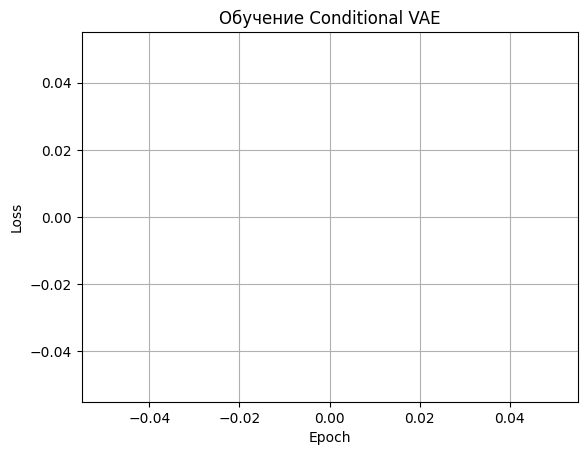

In [28]:
plt.plot(loss_history)
plt.title("Обучение Conditional VAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
def load_pretrained_model(model, checkpoint_path=None):
    """
    Загружает предобученную модель из указанного пути или последнего чекпоинта
    Возвращает: (модель, оптимизатор, start_epoch, best_loss, loss_history)
    """
    start_epoch = 0
    best_loss = float('inf')
    loss_history = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Путь к конкретной модели, которую вы указали
    specific_model_path = "models/generation_model/new data/generate_500k_20of20.pth"
    
    # Определяем, какой файл загружать
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        load_path = checkpoint_path
        print(f"🔍 Загрузка последнего чекпоинта: {load_path}")
    elif os.path.exists(specific_model_path):
        load_path = specific_model_path
        print(f"🔍 Загрузка специфической модели: {load_path}")
    else:
        print("🆕 Модель не найдена. Создается новая модель.")
        return model, optimizer, start_epoch, best_loss, loss_history
    
    try:
        # Загружаем чекпоинт
        checkpoint = torch.load(load_path, map_location=DEVICE)
        
        # Обрабатываем разные форматы сохранения
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Формат чекпоинта с метаданными
            model.load_state_dict(checkpoint['model_state_dict'])
            
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            start_epoch = checkpoint.get('epoch', 0) + 1
            best_loss = checkpoint.get('best_loss', float('inf'))
            loss_history = checkpoint.get('loss_history', [])
            
            print(f"✅ Чекпоинт загружен успешно! Продолжаем с эпохи {start_epoch}")
            print(f"📊 Лучший loss: {best_loss:.4f}")
            print(f"📈 Количество сохраненных эпох в истории: {len(loss_history)}")
        
        else:
            # Просто state_dict модели
            model.load_state_dict(checkpoint)
            print("✅ Веса модели загружены успешно! Начинаем обучение с нуля.")
        
        # Перемещаем модель на правильное устройство
        model = model.to(DEVICE)
        
    except Exception as e:
        print(f"❌ Ошибка при загрузке модели: {str(e)}")
        print("🔄 Создается новая модель для обучения с нуля.")
    
    return model, optimizer, start_epoch, best_loss, loss_history

In [25]:
# Загружаем модель либо из конкретного пути, либо из последнего чекпоинта

# Если вы хотите использовать конкретную версию для генерации без обучения:
USE_MODEL_FOR_GENERATION_ONLY = True
#checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_conditional.pth')
model, optimizer, start_epoch, best_loss, loss_history = load_pretrained_model(
    model, 
    checkpoint_path=None  # Установите в None для загрузки вашей специфической модели
)

🔍 Загрузка специфической модели: models/generation_model/new data/generate_500k_20of20.pth
✅ Веса модели загружены успешно! Начинаем обучение с нуля.


[12:59:48] SMILES Parse Error: extra open parentheses while parsing: [*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5ccccc5)(c5ccccc5)c5ccc(C(C)(C)c6ccc7c(c6)C(=O)N(c6cccc8c6C(=O)N([*])C8=O)C7=O)cc5)cc4)
[12:59:48] SMILES Parse Error: check for mistakes around position 9:
[12:59:48] [*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5
[12:59:48] ~~~~~~~~^
[12:59:48] SMILES Parse Error: extra open parentheses while parsing: [*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5ccccc5)(c5ccccc5)c5ccc(C(C)(C)c6ccc7c(c6)C(=O)N(c6cccc8c6C(=O)N([*])C8=O)C7=O)cc5)cc4)
[12:59:48] SMILES Parse Error: check for mistakes around position 17:
[12:59:48] [*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5
[12:59:48] ~~~~~~~~~~~~~~~~^
[12:59:48] SMILES Parse Error: Failed parsing SMILES '[*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5ccccc5)(c5ccccc5)c5ccc(C(C)(C)c6ccc7c(c6)C(=O)N(c6cccc8c6C(=O)N([*])C8=O)C7=O)cc5)cc4)' for input: '[*]c1ccc(-c2cccc(-c3cc(C)c(Cc4ccc([Si](c5ccccc5)(c5ccccc5)c5ccc(C(C)(C)c6ccc7c(c6)C(=O)N(c6cccc8c6C(=O)N([*])C8=O)C7


Generated SMILES:
[1] [*]NC(=O)c1ccc(S(=O)(=O)Oc2ccc(-c3nc(-c4cccs4)nc(-c4c(Br)cc([*])cc4Br)n3)cc2)cc1 → ✅ VALID
[2] [*]Oc1ccc(-c2cccc(-n3c4ccccc4c4cc(-c5cc([*])c6ccccc6n5)ccc43)c2C(C)(C)C)cc1C → ✅ VALID
[3] [*]Oc1ccc(N=C2OC(=O)c3ccc(Nc4cccc(-c5ccc(C(C)=Nc6ccc(C(C)=Nc7ccccc7)cc6)cc5)c4)cc32)c([N+](=O)[O-])c1 → ✅ VALID
[4] [*]Oc1ccc(C(F)(F)F)cc1-c1cc(C)c(-c2ccc([*])cc2)c(C)c1 → ✅ VALID
[5] [*]OC(=O)c1ccc(S(=O)(=O)c2ccc(Sc3ccc4ccccc4c3C(=O)NNC(=O)c3ccc(S(=O)(=O)c4ccc(O[*])cc4)cc3)cc2)cc1 → ✅ VALID
[6] [*]c1cc(-c2ccc3c(c2)C(=O)N(c2ccc(Oc4ccc(-c5ccc(N=Nc6ccc([N+](=O)[O-])cc6Cl)cc5)cc4)c([*])c2)C3=O)c(C)cc1C → ✅ VALID
[7] [*]C(=O)c1ccc(N2C(=O)N(c3ccc([*])cc3)C(C)(c3ccc(-c4ccc(N=Nc5ccc([N+](=O)[O-])cc5Cl)cc4)cc3)C2=O)cc1 → ✅ VALID
[8] [*]Oc1cccc(N2C(=O)C(Cl)=C(Oc3ccc4c(c3)C(=O)N(c3ccc5c(c3)C(=O)N(C(N3C(=O)c6ccc([*])cc6C3=O)(C(F)(F)F)C(F)(F)F)C5=O)C4=O)C2=O)c1 → ✅ VALID
[9] [*]Cc1nc2cc(-c3ccc(S(=O)(=O)c4ccc(-c5ccc(N6C(=O)c7ccc(CCCC([*])=O)cc7C6=O)cc5Cl)cc4)cc3)ccc2[nH]1 → ✅ VALID
[10] [*]OCC

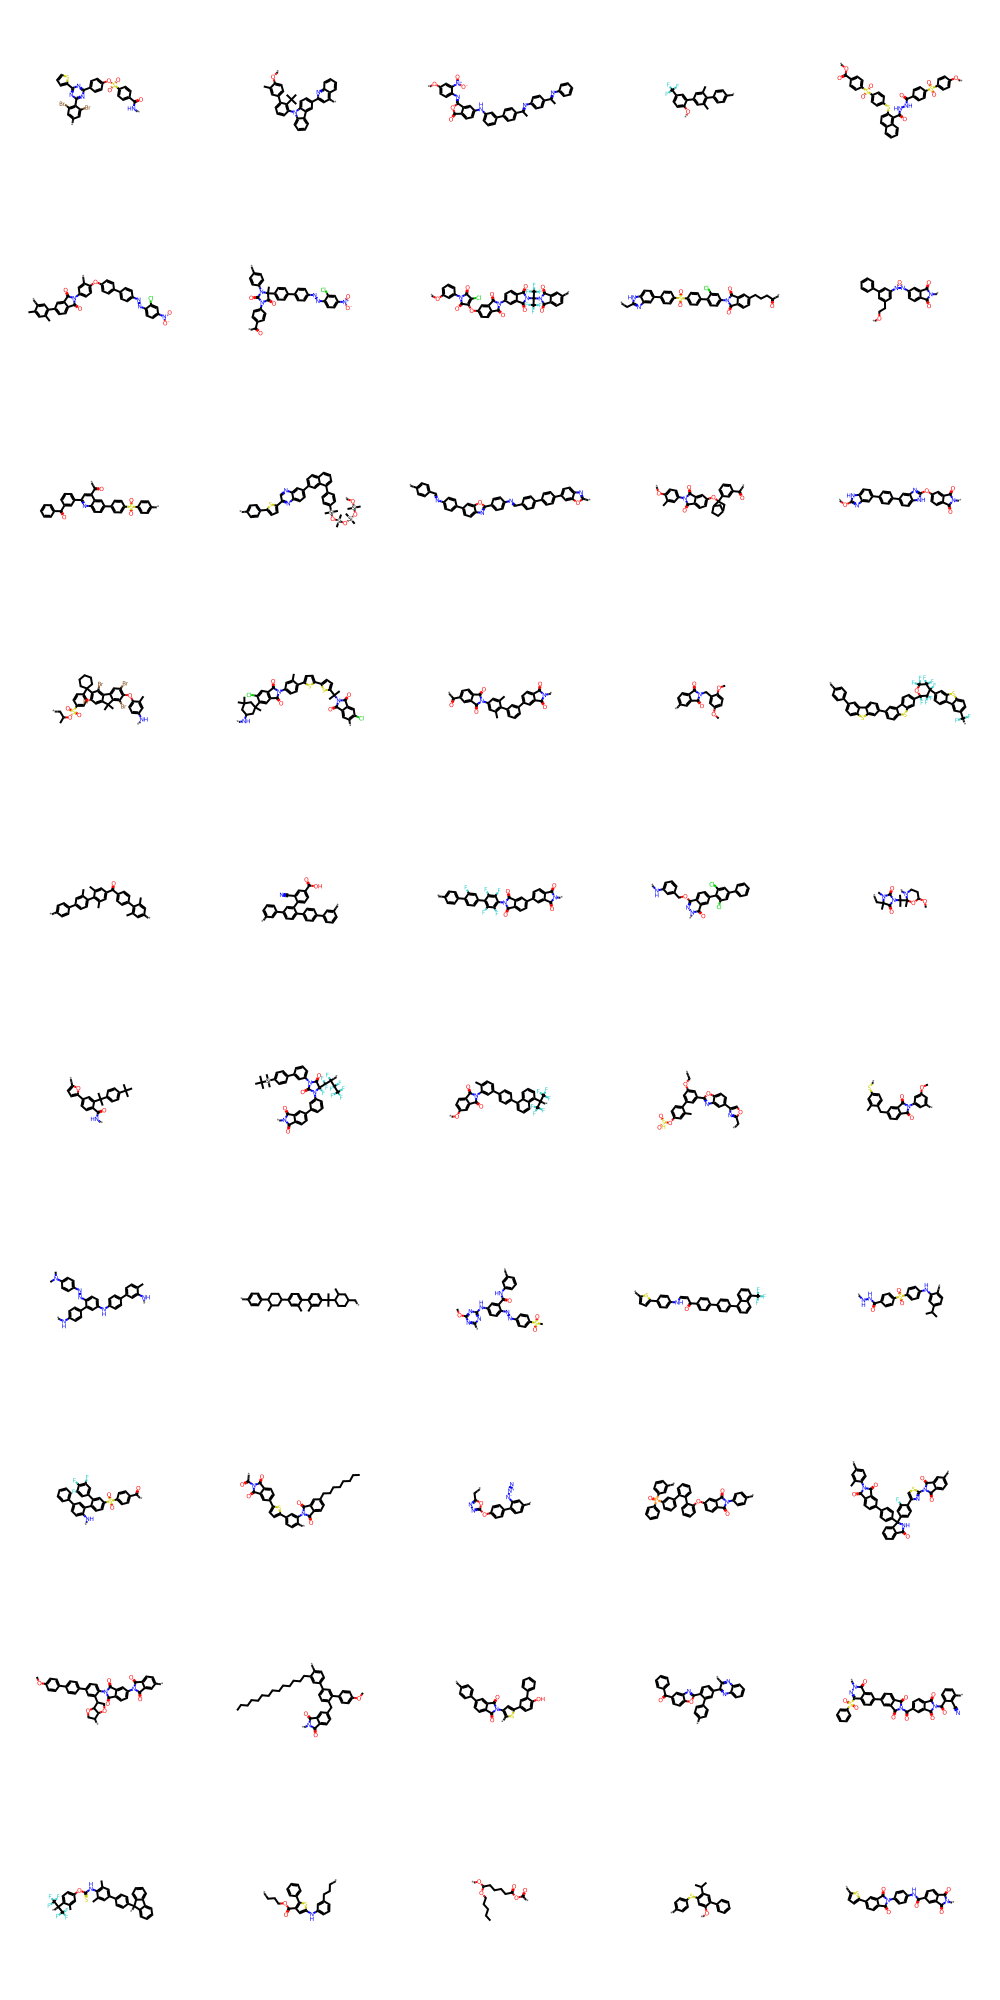

In [32]:
def generate_and_display_conditional(model, dataframe, num_samples=100):
    model.eval()
    # Берем реальные признаки из датасета
    sample_feats = torch.tensor(dataframe[NUM_FEATURES].iloc[:num_samples].values, dtype=torch.float32).to(DEVICE)

    # Генерация
    smiles_list = generate_smiles_conditional(model, sample_feats, num_samples=num_samples)

    # Проверка валидности
    valid_smiles = [s for s in smiles_list if is_valid_smiles(s)]
    valid_mols = [Chem.MolFromSmiles(s) for s in valid_smiles]

    # Вывод результатов
    print("\nGenerated SMILES:")
    for i, s in enumerate(smiles_list):
        status = "✅ VALID" if is_valid_smiles(s) else "❌ INVALID"
        print(f"[{i+1}] {s} → {status}")

    print(f"\n✅ Valid: {len(valid_smiles)} / {len(smiles_list)}")

    # Визуализация валидных молекул
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200,200))
        display(img)
    else:
        print("Нет валидных молекул для визуализации")

# Используем функцию после обучения
generate_and_display_conditional(model, subset_df, num_samples=100)

In [59]:
torch.save(model.state_dict(), "transformer_smiles_conditional.pth")